# XAS Workflow Task 2

This notebook contains the second task of the XAS processing workflow. 

The break up of the task consist of the following steps 

|Task                            | Input                                         | Output
|-------------                   |-------------                                  |-----  
| Curve fitting||
| 1. Import data                |File: FeS2_larch.prj                              |
| 2. Import Crystal data        |File: FeS2.inp                                 |
| 3. Calculate Paths(Atoms+FEFF)||
| 4. Set path parameters        | Parameters:                                   |
|                                 |    amp  = 1                                   |
|                                 |    enot = 0                                   |
|                                 |    delr = 0                                   |
|                                 |    ss   = 0.003                               |
| 5. Select paths                 |                                               |
| 6. Run Fit                    |                                               |
| 7. Save project               ||
| 8. Verify fit results         ||
| 8.1 If not OK revise parameners and refit (go to 2.4)||
| 8.2 If OK Save project and outputs|                                           |File: FeS2_01.fpj

For more details about larch, see https://xraypy.github.io/xraylarch/xafs/


In [1]:
# managing athena files
from larch.io import create_athena, read_athena, extract_athenagroup

project_name = 'FeS2_larch.prj'

fes2_prj = read_athena(project_name)

group_keys = list(fes2_prj._athena_groups.keys())

group_names = {}

for group_key in group_keys:
    group_names[group_key] = group_key

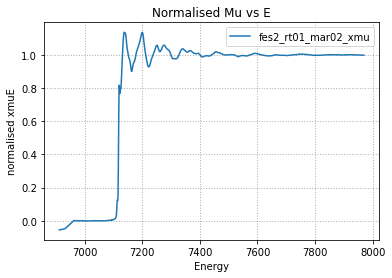

In [2]:
# required larch modules
# calculate pre-edge and post edge for normalisation
from larch.xafs import pre_edge
# perform background removal
from larch.xafs import autobk
# calculate fourier transform
from larch.xafs import xftf

%matplotlib inline
import matplotlib.pyplot as plt

 #######################################################
# |         Athena recalculates everything so we      | #
# |      need to create a function that calculates    | #
# V               all for each new group              V #
 #######################################################

def calc_with_defaults(xafs_group):
    # calculate mu and normalise with background extraction
    # should let the user specify the colums for i0, it, mu, iR. 
    if not hasattr(xafs_group, 'mu'):
        xafs_group = get_mu(xafs_group)
    # calculate pre-edge and post edge and add them to group
    # need to read parameters for pre-edge before background calculation with  
    # defaul values undo the work of previous step (setting pre-edge limits).
    pre_edge(xafs_group, pre1=xafs_group.bkg_params.pre1, pre2=xafs_group.bkg_params.pre2)
    #pre_edge(xafs_group)
    # perform background removal
    autobk(xafs_group) # using defaults so no additional parameters are passed
    # calculate fourier transform
    xftf(xafs_group)#, kweight=0.5, kmin=3.0, kmax=12.871, dk=1, kwindow='Hanning')
    return xafs_group


 #######################################################
# |       The code for plotting Nmu vs E repeats      | #
# |   so it is useful to have a plotting function     | #
# V            to reduce duplicated code              V #
 #######################################################
# plot mu vs flat normalised mu for selected groups
def plot_NxmuE_E_athena_prj(athena_project, group_keys, group_names,
                            title = "Normalised Mu vs E", xlimits = None,
                            ylimits = None):    
    # plot mu vs flat normalised mu for selected groups
    for group_key in group_keys:
        gr_0 = extract_athenagroup(athena_project._athena_groups[group_key])
        # recalculate normalisation
        calc_with_defaults(gr_0)
        plt.plot(gr_0.energy, gr_0.flat, label=group_names[group_key])

    # set plot format
    plt.xlabel("Energy")
    plt.ylabel("normalised xmuE" )
    plt.title(title)
    plt.grid(linestyle=':', linewidth=1) #show and format grid
    if xlimits != None:
        plt.xlim(xlimits[0],xlimits[1])
    if ylimits != None:
        plt.ylim(ylimits[0],ylimits[1])
    plt.legend()
    return plt, gr_0

# plot normalised mu on energy
# plot mu vs flat normalised mu for selected groups
plt, data_group = plot_NxmuE_E_athena_prj(fes2_prj, group_keys, group_names)
plt.show()


## Atoms and FEFF 

Larch does larch does not include a means for running atoms. Atoms is needed to get input for feff and calculate paths. Currently, the fastest option is to run Artemis to obtain the input (.inp) file for feff from a crystal file ('.cif' or '.inp')

The code below shows how subprocess can be used to call perl, execute a small perl script that runs Artemis Atoms, and saves the output file ('inp') in a new directory.

The file can then be used to run FEFF from Larch to calculate scattering paths.

In [3]:
# larch does not include a means for running atoms
# need to get input for feff and calculate paths

# currently the fastest option is to run Artemis to
# obtain the input (.inp) file for feff from a '.cif'
# or '.inp' file

# get subprocess to run perl script
import subprocess

# get the input file
var = "FeS2.inp"

retcode = subprocess.call(["perl", "feff_inp.pl", var])
if retcode == 0:
    print("Passed!")
else:
    print("Failed!")

# run feff and get the paths
from larch.xafs.feffrunner import feff6l
#feff6l(folder='.', feffinp='feff.inp', verbose=True)
feff6l(folder = './fes2_feff',feffinp='fes2_feff.inp' )

Passed!
 : ======== running Feff module C:\Users\scman1\Anaconda3\envs\python36\lib\site-packages\larch\bin\win32\feff6l.exe ========
 : Feff 6L.02
 : name:     Iron sulfide (pyrite)
 : formula:  FeS_2
 : refer1:   Elliot (1960) J.Chem. Phys. 33(3), 903.
 : Calculating potentials and phases...
 : free atom potential and density for atom type    0
 : free atom potential and density for atom type    1
 : free atom potential and density for atom type    2
 : overlapped potential and density for unique potential    0
 : overlapped potential and density for unique potential    1
 : overlapped potential and density for unique potential    2
 : muffin tin radii and interstitial parameters
 : phase shifts for unique potential    0
 : phase shifts for unique potential    1
 : phase shifts for unique potential    2
 : Preparing plane wave scattering amplitudes...
 : nncrit in prcrit       9
 : Searching for paths...
 : Rmax  6.0000  keep and heap limits   0.0000000   0.0000000
 : Preparing neigh

<External Feff Group: ./fes2_feff\fes2_feff.inp>

## Set Parameters
The following code creates the parameters group (GDS in Artemis). The codeuses lp.fitting.param_group and lp.fitting.param instead of importing Group and Parameter (does not work with Jupyter).

The parameter values are the same used in [Bruce Ravel's example](https://github.com/bruceravel/demeter/tree/master/examples/recipes/FeS2).

In [5]:
# set parameters 
# example Using Larch with python3
from larch import Interpreter
import larch_plugins as lp

# library containign functions that read and write to csv files
import lib.handle_csv as csvhandler

session = Interpreter()


# read parameters from csv file
# each line contains a parameter defined as follows
##############################
# id,name,value,expr,vary
# 1,alpha,1e-07,,True
# 2,ss2,0.003,,True
# 3,ss3,0.003,ss2,False
# 4,ssfe,0.003,,True
##############################
def read_gds(gds_file):
    dgs_group = lp.fitting.param_group(_larch=session)
    gds_pars, _ = csvhandler.read_csv_data(gds_file)
    for par_idx in gds_pars:
        #gds file structure:
        gds_name = gds_pars[par_idx]['name']
        gds_val = 0.0
        gds_expr = ""
        try:
            gds_val = float(gds_pars[par_idx]['value'])
        except ValueError:
            #print("Not a float value")
            gds_val = 0.00
        gds_expr = gds_pars[par_idx]['expr']
        gds_vary = True if gds_pars[par_idx]['vary']=='True' else False
        one_par = None
        if gds_vary:
            # equivalent to a guess parameter in Demeter
            one_par = lp.fitting.guess(name=gds_name ,value=gds_val, vary=gds_vary, expr=gds_expr)
        else:
            # equivalent to a defined parameter in Demeter
            one_par = lp.fitting.param(name=gds_name ,value=gds_val, vary=gds_vary, expr=gds_expr)
        if one_par != None:
            dgs_group.__setattr__(gds_name,one_par)
    return dgs_group

# save parameters from csv file
# each line contains a parameter defined as follows
##############################
# id,name,value,expr,vary
# 1,alpha,1e-07,,True
# 2,ss2,0.003,,True
# 3,ss3,0.003,ss2,False
# 4,ssfe,0.003,,True
##############################
def save_gds(dgs_group, gds_file):
    gds_params = dgs_group.__params__
    gds_count = 1
    gds_list = {}
    for par in gds_params:
        gds_list[gds_count] = {'id': gds_count,
                               'name':par,
                               'value':gds_params[par].value,
                               'expr':gds_params[par].expr,
                               'vary':gds_params[par].vary
                              }
        gds_count += 1
    csvhandler.write_csv_data(gds_list,gds_file)
    
gds = read_gds('FeS2_gds.csv')
#save_gds(gds, "FeS2_gds.csv")

## Select Paths
The selection of scattering paths aims at obtaining a list of paths to be used for the fit. For Larch the list must contain specially built *FeffPathGroup* objects. The creation of the path list has been separated in three stages: 
1. **Show feff paths** and allow selecting the ones to be used
2. Show selected paths **Assing parameters** and allow assigning parameters to them
3. **Create selected paths list** contating *FeffPathGroup* objects from larch

   The goal is to obtain a list of 
The first activity requires selecting paths from the FEFF directory. These paths are stored by feff in the files.dat

Each scattering path is loaded while setting the amplitude, $\Delta E_0$, $\Delta R$ and $\sigma^2$ parameters using the GDS parameters defined previously.

The groups are then added to a list of paths to be used for the fit.

### 1 Show all FEFF paths 

To select a path change the value of the select column to 1 in the table displayed after running the cell below.


In [6]:
# regular expression matching
import re
# display editable spreadsheet
import ipysheet
# File handling
from pathlib import Path
#library for writing to log
import logging

# show the paths stored in path files in the FEFF directory.
# These paths are stored by feff in the files.dat file
def show_feff_paths(var = "FeS2.inp"):
    crystal_f = Path(var)
    feff_dir = crystal_f.name[:-4]+"_feff"
    feff_inp = crystal_f.name[:-4]+"_feff.inp"
    feff_files = "files.dat"
    input_file = Path(feff_dir, feff_files)
    #check if feff dir exists
    if input_file.parent.exists() and input_file.exists():
        logging.info(str(input_file.parent) + " path and "+ str(input_file)+ " found")
    else:
        logging.info(str(input_file.parent) + " path not found, run feff before running select paths")
        return False
    count = 0
    # the .dat data is stored in fixed width strings 
    field_widths = [[0,13],[14,21],[22,31],[32,41],[42,48],[49,61]]
    is_meta = True
    data_headers = []
    path_count = 0
    paths_data = []
    logging.info("Reading from: "+ str(input_file))
    with open(input_file) as datfile:
        dat_lines = datfile.readlines()
        for a_line in dat_lines:
            count += 1
            if re.match('-*', a_line.strip()).group(0)!= '':
                is_meta = False
                logging.info("{}: {}".format(count, a_line.strip()))
            elif is_meta:
                logging.info("{}: {}".format(count, a_line.strip()))
            elif data_headers == []:
                data_headers = [a_line[s:e].strip().replace(' ','_') for s,e in field_widths]
                logging.info("headers:"+ str(data_headers))
                data_headers.append('select')
                paths_data.append(data_headers)
            else:
                path_count += 1
                data_values = [a_line[s:e].strip() for s,e in field_widths]
                data_values.append(0)
                data_values[0] = feff_dir+"/"+data_values[0]
                paths_data.append(data_values)
    # use data to populate spreadsheet
    
    path_sheet = ipysheet.sheet(rows=path_count+1, columns=7)
    ipysheet.cell_range(paths_data)
    return path_sheet

path_sheet = show_feff_paths('FeS2.inp')
display(path_sheet)


[root] INFO : FeS2_feff path and FeS2_feff\files.dat found
[root] INFO : Reading from: FeS2_feff\files.dat
[root] INFO : 1: name:     Iron sulfide (pyrite)                        Feff 6L.02  potph 4.12
[root] INFO : 2: formula:  FeS_2
[root] INFO : 3: refer1:   Elliot (1960) J.Chem. Phys. 33(3), 903.
[root] INFO : 4: Abs   Z=26 Rmt= 1.116 Rnm= 1.361 K shell
[root] INFO : 5: Pot 1 Z=26 Rmt= 1.121 Rnm= 1.372
[root] INFO : 6: Pot 2 Z=16 Rmt= 1.120 Rnm= 1.390
[root] INFO : 7: Gam_ch=1.325E+00 H-L exch
[root] INFO : 8: Mu=-4.281E+00 kf=2.108E+00 Vint=-2.122E+01 Rs_int= 1.720
[root] INFO : 9: -------------------------------------------------------------------------------
[root] INFO : headers:['file', 'sig2', 'amp_rati', 'deg', 'nlegs', 'r_effective']


Sheet(cells=(Cell(column_end=6, column_start=0, row_end=48, row_start=0, squeeze_column=False, squeeze_row=Fal…

### 2 Assing parameters to paths
To define the parameters enter values like those presented in the table below into the spreadsheet that appears after running the code in the following cell. The values should correspond to those defined as GDS parameters previously.

|file                  |label | s02 |e0   |sigma2 |deltar      |
|----------------------|------|-----|-----|-------|------------|
|FeS2_feff/feff0001.dat|S1    |amp  |enot |ss     |alpha\*reff |
|FeS2_feff/feff0002.dat|S2    |amp  |enot |ss2    |alpha\*reff |
|FeS2_feff/feff0003.dat|S3    |amp  |enot |ss3    |alpha\*reff |
|FeS2_feff/feff0004.dat|Fe    |amp  |enot |ssfe   |alpha\*reff |


**Note:** Labelling is used for reference only using Artemis-FEFF given names. Larch's FEFF does not label paths.

In [7]:
def show_selected_paths(pats_sheet):
    df_sheet = ipysheet.to_dataframe(pats_sheet)
    files = []
    for f_name, selected in zip(df_sheet["A"], df_sheet["G"]):
        if selected == '1':
            files.append(f_name)    

    sel_paths_data = [[0 for col in range(6)] for row in range(4)]
    sel_paths_data[:0]=[['file','label','s02','e0','sigma2','deltar']]
    ps_row = 1
    for a_name in files:
        sel_paths_data[ps_row][0] = a_name
        ps_row += 1

    sp_sheet = ipysheet.sheet(rows=len(files)+1, columns=6)
    ipysheet.cell_range(sel_paths_data)
    display(sp_sheet)
    return sp_sheet
sp_sheet = show_selected_paths(path_sheet)


Sheet(cells=(Cell(column_end=5, column_start=0, row_end=4, row_start=0, squeeze_column=False, squeeze_row=Fals…

In [8]:
# library containign functions that read and write to csv files
import lib.handle_csv as csvhandler

# use data frame to create selected paths list
def build_selected_paths_list(sp_sheet):
    df_sheet = ipysheet.to_dataframe(sp_sheet).transpose()
    sp_list = []
    for col in df_sheet:
        if df_sheet[col][0] != 'file':
            new_path = lp.xafs.FeffPathGroup(filename = df_sheet[col][0],
                                             label    = df_sheet[col][1],
                                             s02      = df_sheet[col][2],
                                             e0       = df_sheet[col][3],
                                             sigma2   = df_sheet[col][4],
                                             deltar   = df_sheet[col][5],
                                             _larch   = session)
            sp_list.append(new_path)
    return sp_list

def save_selected_paths_list(sp_sheet, f_prefix = "FeS2"):
    # it is easier to transpose as dataframes main objects are columns
    df_sheet = ipysheet.to_dataframe(sp_sheet).transpose()
    sp_list = {}
    path_count = 1
    for col in df_sheet:
        if df_sheet[col][0] != 'file':
            sp_list[path_count] = {'id': path_count,
                                   'filename':df_sheet[col][0],
                                   'label':df_sheet[col][1],
                                   's02':df_sheet[col][2],
                                   'e0':df_sheet[col][3],
                                   'sigma2':df_sheet[col][4],
                                   'deltar':df_sheet[col][5]}
            path_count += 1
    print(sp_list)
    file_name = f_prefix+"_sp.csv"
    csvhandler.write_csv_data(sp_list,file_name)
    
f_prefix = "FeS2"
selected_paths = build_selected_paths_list(sp_sheet)
save_selected_paths_list(sp_sheet)

{1: {'id': 1, 'filename': 'FeS2_feff/feff0001.dat', 'label': 'S1', 's02': 'amp', 'e0': 'enot', 'sigma2': 'ss', 'deltar': 'alpha*reff'}, 2: {'id': 2, 'filename': 'FeS2_feff/feff0002.dat', 'label': 'S2', 's02': 'amp', 'e0': 'enot', 'sigma2': 'ss2', 'deltar': 'alpha*reff'}, 3: {'id': 3, 'filename': 'FeS2_feff/feff0003.dat', 'label': 'S3', 's02': 'amp', 'e0': 'enot', 'sigma2': 'ss3', 'deltar': 'alpha*reff'}, 4: {'id': 4, 'filename': 'FeS2_feff/feff0004.dat', 'label': 'Fe', 's02': 'amp', 'e0': 'enot', 'sigma2': 'ssfe', 'deltar': 'alpha*reff'}}


In [10]:
selected_paths

[<FeffPath Group FeS2_feff/feff0001.dat>,
 <FeffPath Group FeS2_feff/feff0002.dat>,
 <FeffPath Group FeS2_feff/feff0003.dat>,
 <FeffPath Group FeS2_feff/feff0004.dat>]

## Run Fit

XAS fitting is performed in three steps:
1. Create a Transform group to holds the set of Fourier transform parameters, fitting ranges, and space in which the data and sum of paths are to be compared (R space)
2. Create a Dataset group,consistaining of the three components required for fitting(data, paths, and transform group)
3. FEFFIT is run with the list of parameters (gds) for the fit, and the dataset or list of datasets groups.


In [11]:
# run fit
# create the transform grup (prepare the fit space).
trans = lp.xafs.TransformGroup(fitspace='r', kmin=3, kmax=14, kw=2, dk=1, window='hanning', rmin=1.4,
                               rmax=3.0, _larch=session)

dset = lp.xafs.FeffitDataSet(data=data_group, pathlist=selected_paths, transform=trans, _larch=session)

out = lp.xafs.feffit(gds, dset, _larch=session)

## Review fit results
The results of the fit are stored in the dataset. These can be plotted and printed as follows.

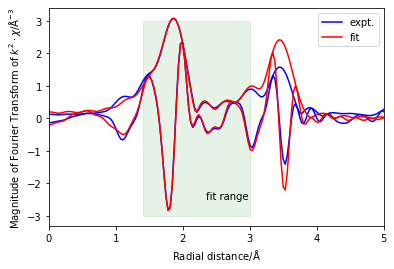

In [12]:
fig = plt.figure()
plt.plot(dset.data.r, dset.data.chir_mag, color='b')
plt.plot(dset.data.r, dset.data.chir_re, color='b', label='expt.')
plt.plot(dset.model.r, dset.model.chir_mag, color='r')
plt.plot(dset.model.r, dset.model.chir_re, color='r', label='fit')
plt.ylabel("Magnitude of Fourier Transform of $k^2 \cdot \chi$/$\mathrm{\AA}^{-3}$")
plt.xlabel("Radial distance/$\mathrm{\AA}$")
plt.xlim(0, 5)

plt.fill([1.4, 1.4, 3.0, 3.0],[-3, 3, 3, -3], color='g',alpha=0.1)
plt.text(2.35, -2.5, 'fit range')
plt.legend()
plt.show()

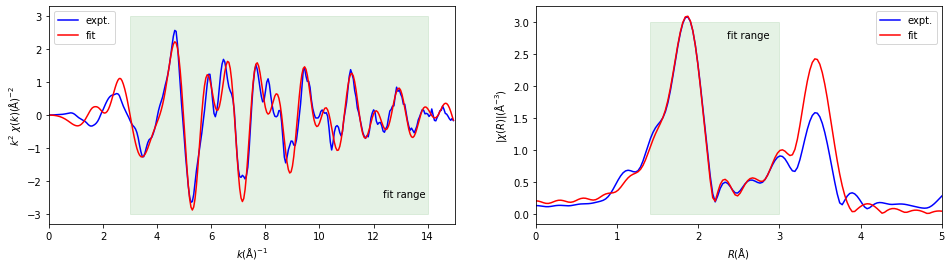

In [13]:
fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
# Creating the chifit plot from scratch
#from larch.wxlib.xafsplots import plot_chifit
#plot_chifit(dset, _larch=session)
ax1.plot(dset.data.k, dset.data.chi*dset.data.k**2, color='b', label='expt.')
ax1.plot(dset.model.k, dset.model.chi*dset.data.k**2 , color='r', label='fit')
ax1.set_xlim(0, 15)
ax1.set_xlabel("$k (\mathrm{\AA})^{-1}$")
ax1.set_ylabel("$k^2$ $\chi (k)(\mathrm{\AA})^{-2}$")
ax1.fill([3.0, 3.0, 14.0, 14.0],[-3, 3, 3, -3], color='g',alpha=0.1)
ax1.text(12.35, -2.5, 'fit range')
ax1.legend()

ax2.plot(dset.data.r, dset.data.chir_mag, color='b', label='expt.')
ax2.plot(dset.model.r, dset.model.chir_mag, color='r', label='fit')
ax2.set_xlim(0, 5)
ax2.set_xlabel("$R(\mathrm{\AA})$")
ax2.set_ylabel("$|\chi(R)|(\mathrm{\AA}^{-3})$")
ax2.legend(loc='upper right')
ax2.fill([1.4, 1.4, 3.0, 3.0],[0, 3, 3, 0], color='g',alpha=0.1)
ax2.text(2.35, 2.75, 'fit range')
plt.show()
 

In [14]:
print(lp.xafs.feffit_report(out, _larch=session))

=================== FEFFIT RESULTS ====================
[[Statistics]]
   nvarys, npts       =  6, 104
   n_independent      =  12.205
   chi_square         =  371.295644
   reduced chi_square =  59.8428826
   r-factor           =  0.00290187
   Akaike info crit   =  53.6807532
   Bayesian info crit =  56.6915855
 
[[Data]]
   fit space          = 'r'
   r-range            = 1.400, 3.000
   k-range            = 3.000, 14.000
   k window, dk       = 'hanning', 1.000
   paths used in fit  = ['FeS2_feff/feff0001.dat', 'FeS2_feff/feff0002.dat', 'FeS2_feff/feff0003.dat', 'FeS2_feff/feff0004.dat']
   k-weight           = 2
   epsilon_k          = Array(mean=5.0753e-04, std=4.5904e-04)
   epsilon_r          = 0.01049725
   n_independent      = 12.205
 
[[Variables]]
   alpha          = -1.3926e-04 +/- 0.00139805   (init=  1.0000e-07)
   amp            =  0.74646922 +/- 0.03128915   (init=  1.00000000)
   enot           =  2.53728893 +/- 0.53436366   (init=  1.0000e-07)
   ss             =  0.